<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Progress_Barometer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for GDP per capita (current US$)...
Fetching data for GNI per capita (current US$)...
Fetching data for Unemployment rate...
Fetching data for Life Expectancy at Birth...
Fetching data for Education Index...
Fetching data for Control of Corruption...
Fetching data for Government Effectiveness...
Fetching data for Political Stability...
Fetching data for Regulatory Quality...
Fetching data for Rule of Law...
Fetching data for Voice and Accountability...

Countries with missing values:
['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CEB', 'CHE', 'CHI', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSS', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'ECU', 'EGY', 'EMU', 'ERI', 'ESP',

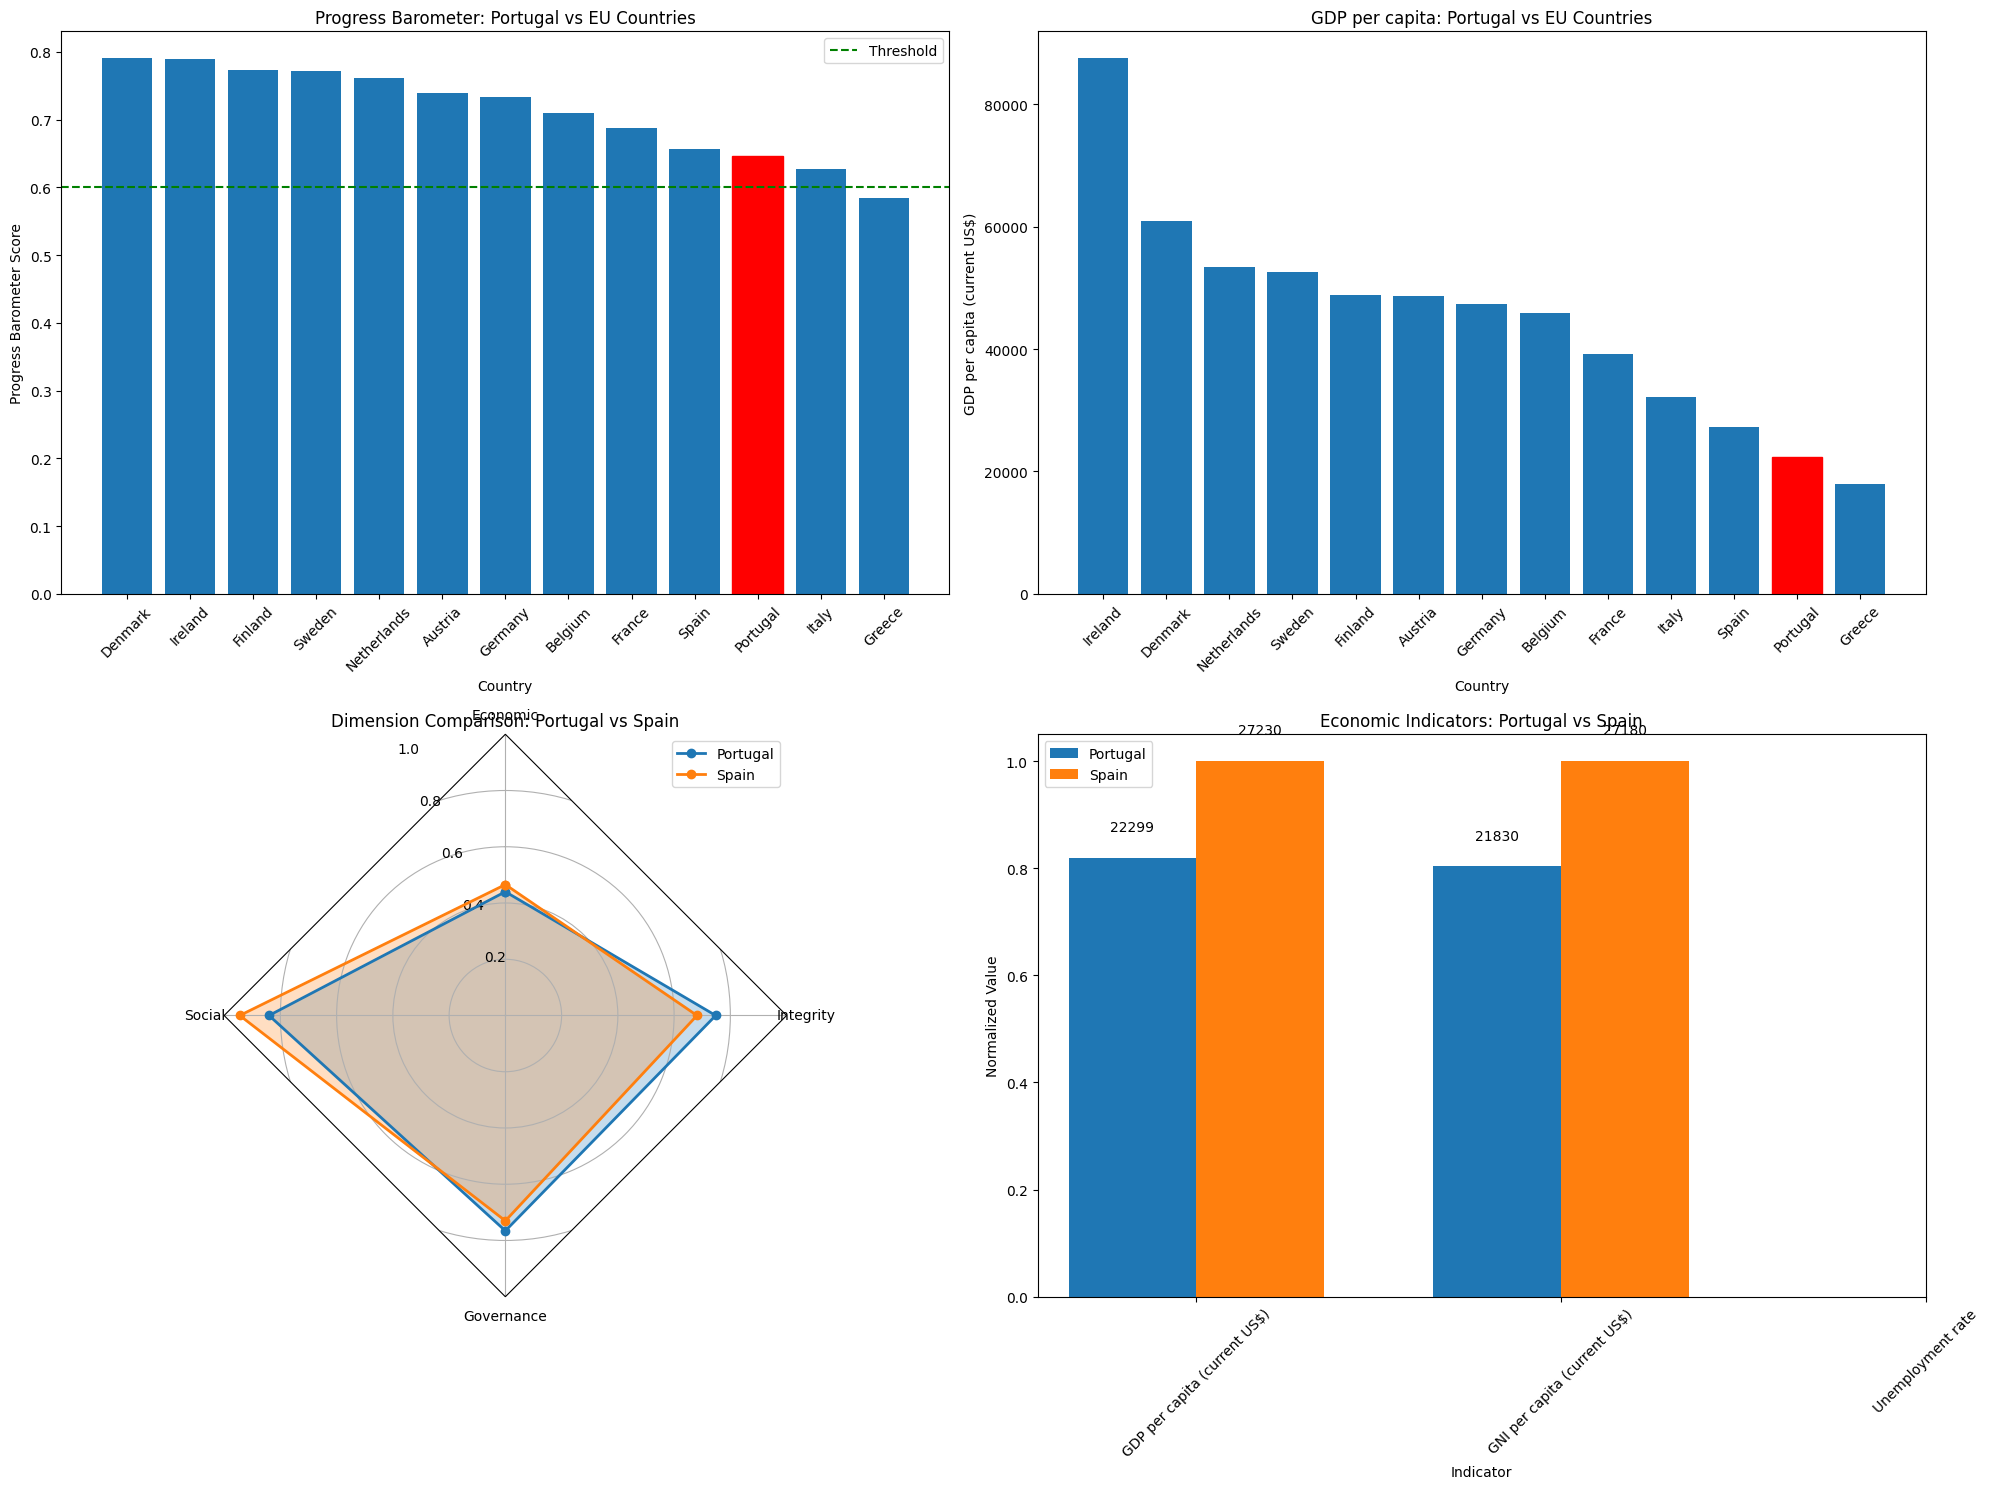


Results saved to CSV files and visualizations saved to PNG


In [ ]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import warnings
warnings.filterwarnings('ignore')

# Define a function for radar chart
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.
    """
    # Calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

# Define a function to fetch data from the World Bank API
def fetch_world_bank_data(indicator, countries="all", date="2020", format="json"):
    base_url = "http://api.worldbank.org/v2"
    url = f"{base_url}/country/{countries}/indicator/{indicator}?date={date}&format={format}&per_page=1000"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1:  # Check if data is available
            return data[1]  # Return the actual data part of the response
        else:
            print(f"No data available for indicator {indicator}")
            return None
    else:
        print(f"Failed to fetch data for indicator {indicator}. Status code: {response.status_code}")
        return None

# Define indicators for the composite index - expanded set with minimum wage
indicators = {
    "GDP per capita (current US$)": "NY.GDP.PCAP.CD",
    "GNI per capita (current US$)": "NY.GNP.PCAP.CD",
    "Unemployment rate": "SL.UEM.TOTL.ZS",
    "Life Expectancy at Birth": "SP.DYN.LE00.IN",
    "Education Index": "SE.ADT.LITR.ZS",  # Literacy rate as proxy
    "Control of Corruption": "CC.EST",
    "Government Effectiveness": "GE.EST",
    "Political Stability": "PV.EST",
    "Regulatory Quality": "RQ.EST",
    "Rule of Law": "RL.EST",
    "Voice and Accountability": "VA.EST"
}

# Define indicator groups for calculation with adjusted economic focus
indicator_groups = {
    "Economic": [
        "GDP per capita (current US$)",
        "GNI per capita (current US$)",
        "Unemployment rate"
    ],
    "Social": [
        "Life Expectancy at Birth",
        "Education Index"
    ],
    "Governance": [
        "Government Effectiveness",
        "Regulatory Quality",
        "Voice and Accountability"
    ],
    "Integrity": [
        "Control of Corruption",
        "Rule of Law",
        "Political Stability"
    ]
}

# Define weights for each group in the final index - adjusted to emphasize economy
group_weights = {
    "Economic": 0.40,  # Increased weight for economic factors
    "Social": 0.20,
    "Governance": 0.20,
    "Integrity": 0.20
}

# Define reverse indicators (where lower values are better)
reverse_indicators = ["Unemployment rate"]

# Function to compare Portugal with specific EU countries
def compare_with_eu(data, portugal_data, indicators_to_compare=None):
    # Define EU countries to compare with
    eu_countries = ["ESP", "DEU", "FRA", "ITA", "GRC", "IRL", "NLD", "BEL", "AUT", "FIN", "SWE", "DNK"]

    # Filter data for EU countries plus Portugal
    eu_data = data[data["Country"].isin(eu_countries + ["PRT"])]

    if indicators_to_compare is None:
        indicators_to_compare = ["GDP per capita (current US$)", "GNI per capita (current US$)", "Unemployment rate"]

    # Create comparison DataFrame
    comparison = pd.DataFrame()
    comparison["Country"] = eu_data["Country"]

    # Add country names
    country_names = {
        "PRT": "Portugal", "ESP": "Spain", "DEU": "Germany",
        "FRA": "France", "ITA": "Italy", "GRC": "Greece",
        "IRL": "Ireland", "NLD": "Netherlands", "BEL": "Belgium",
        "AUT": "Austria", "FIN": "Finland", "SWE": "Sweden", "DNK": "Denmark"
    }
    comparison["Country_Name"] = comparison["Country"].map(country_names)

    for indicator in indicators_to_compare:
        comparison[indicator] = eu_data[indicator]

    # Calculate Portugal's percentage difference with other countries
    for indicator in indicators_to_compare:
        if indicator in reverse_indicators:
            # For indicators where lower is better (like unemployment)
            comparison[f"{indicator}_vs_PRT_%"] = ((comparison[indicator] - portugal_data[indicator].values[0]) /
                                                  portugal_data[indicator].values[0] * 100)
        else:
            # For indicators where higher is better
            comparison[f"{indicator}_vs_PRT_%"] = ((portugal_data[indicator].values[0] - comparison[indicator]) /
                                                 comparison[indicator] * 100)

    # Add Progress Barometer score
    comparison["Progress_Barometer"] = eu_data["Progress_Barometer"]

    return comparison.sort_values("Progress_Barometer", ascending=False)

# Fetch data for each indicator
data_frames = []
for name, code in indicators.items():
    print(f"Fetching data for {name}...")
    data = fetch_world_bank_data(code)
    if data:
        df = pd.DataFrame(data)
        # Check if data has the required columns
        if "countryiso3code" in df.columns and "value" in df.columns:
            # Filter out rows where countryiso3code is empty
            df = df[df["countryiso3code"] != ""]
            df = df[["countryiso3code", "value"]].rename(columns={"countryiso3code": "Country", "value": name})
            data_frames.append(df)
        else:
            print(f"Missing required columns in data for {name}")

# Merge all indicators into a single DataFrame
if len(data_frames) > 1:
    progress_data = pd.merge(data_frames[0], data_frames[1], on="Country", how="outer")
    for i in range(2, len(data_frames)):
        progress_data = pd.merge(progress_data, data_frames[i], on="Country", how="outer")

    # Print countries with missing values to help identify issues
    missing_values = progress_data[progress_data.isna().any(axis=1)]
    if not missing_values.empty:
        print("\nCountries with missing values:")
        print(missing_values["Country"].tolist())

    # Check for Portugal specifically
    if "PRT" in progress_data["Country"].values:
        print("\nPortugal data before filling missing values:")
        print(progress_data[progress_data["Country"] == "PRT"])
    else:
        print("\nPortugal not found in the dataset. Check if it's labeled differently.")

    # Instead of dropping rows with missing values, fill them with median
    for column in indicators.keys():
        progress_data[column] = pd.to_numeric(progress_data[column], errors='coerce')
        median_value = progress_data[column].median()
        missing_count = progress_data[column].isna().sum()
        if missing_count > 0:
            progress_data[column].fillna(median_value, inplace=True)
            print(f"Filled {missing_count} missing values in {column} with median: {median_value}")

    # Calculate group scores
    for group_name, group_indicators in indicator_groups.items():
        # Initialize the group score column
        progress_data[f"{group_name}_Score"] = 0

        # Sum up the normalized indicator values
        for indicator_name in group_indicators:
            # Normalize the indicator
            min_val = progress_data[indicator_name].min()
            max_val = progress_data[indicator_name].max()

            if indicator_name in reverse_indicators:
                # For indicators where lower is better (like unemployment)
                if max_val > min_val:  # Avoid division by zero
                    progress_data[f"{indicator_name}_Normalized"] = 1 - ((progress_data[indicator_name] - min_val) / (max_val - min_val))
                else:
                    progress_data[f"{indicator_name}_Normalized"] = 1  # If all values are the same
            else:
                # For indicators where higher is better
                if max_val > min_val:  # Avoid division by zero
                    progress_data[f"{indicator_name}_Normalized"] = (progress_data[indicator_name] - min_val) / (max_val - min_val)
                else:
                    progress_data[f"{indicator_name}_Normalized"] = 0  # If all values are the same

            # Add to group score
            progress_data[f"{group_name}_Score"] += progress_data[f"{indicator_name}_Normalized"] / len(group_indicators)

    # Calculate the Progress Barometer index with group weights
    progress_data["Progress_Barometer"] = 0
    for group_name, weight in group_weights.items():
        progress_data["Progress_Barometer"] += progress_data[f"{group_name}_Score"] * weight

    # Set a threshold for progress readiness
    threshold = 0.6  # Higher threshold for more stringent evaluation
    progress_data["Progress_Ready"] = progress_data["Progress_Barometer"] > threshold

    # Look for Portugal again
    portugal_data = None
    if "PRT" in progress_data["Country"].values:
        print("\nPortugal's final data:")
        portugal_data = progress_data[progress_data["Country"] == "PRT"]
        print(portugal_data[["Country", "Progress_Barometer", "Progress_Ready"] +
                           [f"{group}_Score" for group in indicator_groups.keys()]])

        # Find Portugal's rank
        sorted_data = progress_data.sort_values("Progress_Barometer", ascending=False).reset_index(drop=True)
        portugal_rank = sorted_data[sorted_data["Country"] == "PRT"].index[0] + 1
        print(f"\nPortugal ranks #{portugal_rank} out of {len(sorted_data)} countries")
        print(f"Portugal's Progress Barometer score: {portugal_data['Progress_Barometer'].values[0]:.4f}")
        print(f"Portugal is {'ABOVE' if portugal_data['Progress_Ready'].values[0] else 'BELOW'} the threshold of {threshold}")

        # Compare with Spain specifically
        if "ESP" in progress_data["Country"].values:
            spain_data = progress_data[progress_data["Country"] == "ESP"]
            print("\nPortugal vs Spain:")
            comparison_columns = ["Progress_Barometer", "Progress_Ready"] + [f"{group}_Score" for group in indicator_groups.keys()]
            comparison_df = pd.DataFrame({
                "Metric": comparison_columns,
                "Portugal": portugal_data[comparison_columns].values[0],
                "Spain": spain_data[comparison_columns].values[0],
                "Difference (%)": [(portugal_data[col].values[0] - spain_data[col].values[0]) /
                                  spain_data[col].values[0] * 100 if col != "Progress_Ready" else "N/A"
                                  for col in comparison_columns]
            })
            print(comparison_df)

            # Compare economic indicators specifically
            print("\nEconomic Indicators Comparison:")
            eco_indicators = ["GDP per capita (current US$)", "GNI per capita (current US$)", "Unemployment rate"]
            eco_comparison = pd.DataFrame({
                "Indicator": eco_indicators,
                "Portugal": [portugal_data[ind].values[0] for ind in eco_indicators],
                "Spain": [spain_data[ind].values[0] for ind in eco_indicators],
                "Portugal vs Spain (%)": [(portugal_data[ind].values[0] - spain_data[ind].values[0]) /
                                        spain_data[ind].values[0] * 100 for ind in eco_indicators]
            })
            print(eco_comparison)

    # Compare with EU countries
    if portugal_data is not None:
        eu_comparison = compare_with_eu(progress_data, portugal_data)
        print("\nComparison with EU countries:")
        print(eu_comparison[[
            "Country_Name", "Progress_Barometer",
            "GDP per capita (current US$)", "GDP per capita (current US$)_vs_PRT_%",
            "GNI per capita (current US$)", "GNI per capita (current US$)_vs_PRT_%",
            "Unemployment rate", "Unemployment rate_vs_PRT_%"
        ]])

    # Display top 10 and bottom 10 countries
    print("\nTop 10 countries by Progress Barometer:")
    top_10 = progress_data.sort_values("Progress_Barometer", ascending=False).head(10)
    print(top_10[["Country", "Progress_Barometer", "Progress_Ready"] +
                [f"{group}_Score" for group in indicator_groups.keys()]])

    print("\nBottom 10 countries by Progress Barometer:")
    bottom_10 = progress_data.sort_values("Progress_Barometer").head(10)
    print(bottom_10[["Country", "Progress_Barometer", "Progress_Ready"] +
                   [f"{group}_Score" for group in indicator_groups.keys()]])

    # Create visualizations
    plt.figure(figsize=(20, 15))

    # Create Portugal vs EU comparison chart
    if portugal_data is not None:
        eu_comparison_filtered = eu_comparison.sort_values("Progress_Barometer", ascending=False)

        # Progress Barometer comparison
        plt.subplot(2, 2, 1)
        bars = plt.bar(eu_comparison_filtered["Country_Name"], eu_comparison_filtered["Progress_Barometer"])

        # Highlight Portugal
        portugal_idx = eu_comparison_filtered[eu_comparison_filtered["Country"] == "PRT"].index[0]
        portugal_pos = list(eu_comparison_filtered.index).index(portugal_idx)
        bars[portugal_pos].set_color("red")

        plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold")
        plt.xlabel("Country")
        plt.ylabel("Progress Barometer Score")
        plt.title("Progress Barometer: Portugal vs EU Countries")
        plt.xticks(rotation=45)
        plt.legend()

        # GDP comparison
        plt.subplot(2, 2, 2)
        gdp_comparison = eu_comparison_filtered.sort_values("GDP per capita (current US$)", ascending=False)
        bars = plt.bar(gdp_comparison["Country_Name"], gdp_comparison["GDP per capita (current US$)"])

        # Highlight Portugal
        portugal_idx = gdp_comparison[gdp_comparison["Country"] == "PRT"].index[0]
        portugal_pos = list(gdp_comparison.index).index(portugal_idx)
        bars[portugal_pos].set_color("red")

        plt.xlabel("Country")
        plt.ylabel("GDP per capita (current US$)")
        plt.title("GDP per capita: Portugal vs EU Countries")
        plt.xticks(rotation=45)

        # Create radar chart for Portugal vs Spain
        if "ESP" in progress_data["Country"].values:
            categories = list(indicator_groups.keys())
            N = len(categories)

            # Create theta for radar chart
            theta = radar_factory(N, frame='polygon')

            ax = plt.subplot(2, 2, 3, projection='radar')

            # Get Portugal and Spain data
            portugal = portugal_data
            spain = progress_data[progress_data["Country"] == "ESP"]

            # Format the data for the radar chart
            values_portugal = [portugal[f"{cat}_Score"].values[0] for cat in categories]
            values_spain = [spain[f"{cat}_Score"].values[0] for cat in categories]

            # Plot the radar chart
            ax.plot(theta, values_portugal, 'o-', linewidth=2, label='Portugal')
            ax.fill(theta, values_portugal, alpha=0.25)
            ax.plot(theta, values_spain, 'o-', linewidth=2, label='Spain')
            ax.fill(theta, values_spain, alpha=0.25)

            ax.set_varlabels(categories)
            ax.set_ylim(0, 1)
            ax.legend(loc='upper right')
            plt.title("Dimension Comparison: Portugal vs Spain")

        # Create economic metrics comparison chart
        plt.subplot(2, 2, 4)

        # Get economic indicators
        economic_indicators = ["GDP per capita (current US$)", "GNI per capita (current US$)", "Unemployment rate"]
        x = np.arange(len(economic_indicators))
        width = 0.35

        # Get data for Portugal and Spain
        if "ESP" in progress_data["Country"].values:
            portugal_values = [portugal_data[ind].values[0] for ind in economic_indicators]
            spain_values = [progress_data[progress_data["Country"] == "ESP"][ind].values[0] for ind in economic_indicators]

            # Normalize for better visualization
            max_values = [max(p, s) for p, s in zip(portugal_values, spain_values)]
            portugal_norm = [p/m for p, m in zip(portugal_values, max_values)]
            spain_norm = [s/m for s, m in zip(spain_values, max_values)]

            # Create the bar chart
            plt.bar(x - width/2, portugal_norm, width, label='Portugal')
            plt.bar(x + width/2, spain_norm, width, label='Spain')

            plt.xlabel('Indicator')
            plt.ylabel('Normalized Value')
            plt.title('Economic Indicators: Portugal vs Spain')
            plt.xticks(x, economic_indicators, rotation=45)
            plt.legend()

            # Add value labels
            for i, v in enumerate(portugal_values):
                plt.text(i - width/2, portugal_norm[i] + 0.05, f"{v:.0f}", ha='center')

            for i, v in enumerate(spain_values):
                plt.text(i + width/2, spain_norm[i] + 0.05, f"{v:.0f}", ha='center')

    plt.tight_layout()
    plt.savefig("portugal_eu_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Save full results to CSV for further analysis
    progress_data.to_csv("progress_barometer_results.csv", index=False)
    if portugal_data is not None and "ESP" in progress_data["Country"].values:
        eu_comparison.to_csv("portugal_eu_comparison.csv", index=False)

    print("\nResults saved to CSV files and visualizations saved to PNG")
else:
    print("Not enough data to calculate the Progress Barometer.")